In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
from sklearn.linear_model.coordinate_descent import ConvergenceWarning   # 拦截异常

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV,LinearRegression

from sklearn.model_selection import train_test_split

In [6]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

##### 1、数据加载 + 数据处理

In [7]:
path = "datas/breast-cancer-wisconsin.data"
names = ['id','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape',
         'Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']

df = pd.read_csv(path, header=None,sep=',',names=names)  # —— names ：标题 ，重给了标题

datas = df.replace('?', np.nan).dropna(how = 'any')
datas.head(5)

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


##### 2、数据划分 + 数据分割

In [19]:
X = datas[names[1:10]]   # 第0列是id列，不要
Y = datas[names[-1]]   # 或Y = datas.columns[10]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)

##### 3、数据预处理 - 标准化

In [20]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

##### 4、模型构建（CV） + 训练 + 预测
—— LogisticRegressionCV() 逻辑回归算法（交叉验证型）
    
    -》multi_class: 多元分类方式；ovr(默认)、multinomial；这两种方式在二元分类问题中，效果是一样的；在多元分类问题中，效果不一样
    ①、ovr: one-vs-rest，对于多元分类的问题，先将其看做二元分类，分类完成后，再对其中一类继续进行二元分类，依次迭代
    ②、multinomial: many-vs-many（MVM）,对于多元分类问题，如果模型有T类，我们每次在所有的T类样本里面选择两类样本出来，进行二元逻辑回归。一共需要T(T-1)/2次分类

    -》Cs: 正则化强度的反比
    -》penalty: 惩罚项（正则项），过拟合解决方案,参数等于 l1 或 l2
    -》solver: 参数优化方式 
    ①、当penalty为l1的时候，solver只能是liblinear(坐标轴下降法)，lbfgs和cg都是关于目标函数的二阶泰勒展开
    ②、当penalty为l2的时候，solver可以是seg(mini-batch梯度下降)、lbfgs(拟牛顿法)、newton-cg(牛顿法变种)
    维度<10000时，lbfgs法比较好 ；维度>10000时， cg法比较好 ；显卡计算时，lbfgs和cg都比seg快

    -》tol: 标准公差阈值，小于该数时，迭代停止

In [21]:
lr = LogisticRegressionCV(multi_class='ovr',fit_intercept=True, cv=2, Cs=np.logspace(-2, 2, 20), penalty='l2', solver='lbfgs', tol=0.01)
lr.fit(X_train, Y_train)

Y_predict = lr.predict(X_test)

##### 5、模型评估
假定在一个k分类问题中，测试集中共有n个样本。则：

—— predict 返回的是一个n行1列的数组，一维数组中的第i个值为模型预测的第i个样本的预测标签；

—— predict_proba 返回的是一个n行k列的数组，第i行第j列上的数值是模型预测的第i个预测样本的标签为j的概率；每行的概率和为1。
可以理解为，返回预测属于某标签的概率，有多少个分类结果，每行就有多少个概率

In [22]:
print ("R^2（准确率）：", lr.score(X_train, Y_train))
print ("参数：",lr.coef_)
print ("截距：",lr.intercept_)   # 偏置项
print ("稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))   # 相连的 %% 用于表示 %

print(lr.predict_proba(X_test)[0:5])   # 二分类时，概率大的为当前标签。

R^2（准确率）： 0.970684039088
参数： [[ 1.3926311   0.17397478  0.65749877  0.8929026   0.36507062  1.36092964
   0.91444624  0.63198866  0.75459326]]
截距： [-1.02717163]
稀疏化特征比率：0.00%
[[ 0.99402766  0.00597234]
 [ 0.99481448  0.00518552]
 [ 0.1017864   0.8982136 ]
 [ 0.0169779   0.9830221 ]
 [ 0.99866407  0.00133593]]


##### 附加  模型相关信息保存 + 加载

In [12]:
from sklearn.externals import joblib
# 要求文件夹必须存在
joblib.dump(ss, "datas/logistic/ss.model")   ## 保存标准化模型
joblib.dump(lr, "datas/logistic/lr.model")   ## 保存模型

['datas/logistic/lr.model']

In [13]:
# 模型加载
oss = joblib.load("datas/logistic/ss.model")
olr = joblib.load("datas/logistic/lr.model")

##### 6、绘制图形

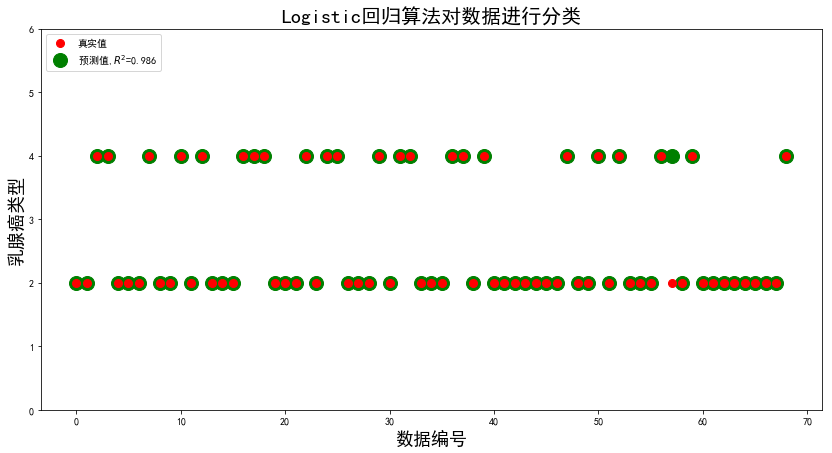

In [14]:
x_len = range(len(X_test))

plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(0,6)

plt.plot(x_len, Y_test, 'ro',markersize = 8, zorder=3, label='真实值')   # —— markersize 标记大小
plt.plot(x_len, Y_predict, 'go', markersize = 14, zorder=2, label='预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.legend(loc = 'upper left')

plt.xlabel('数据编号', fontsize=18)   # x轴一般都是数据编号，只是测试值的特征值长度，没有实际物理意义
plt.ylabel('乳腺癌类型', fontsize=18)
plt.title('Logistic回归算法对数据进行分类', fontsize=20)
plt.show()

# logistic算法预测实例

In [40]:
from sklearn.linear_model import LogisticRegression
import numpy as np

x_train = np.array([[1,2,3],
                    [1,3,4],
                    [2,1,2],
                    [4,5,6],
                    [3,5,3],
                    [1,7,2]])

y_train = np.array([3, 3, 3, 3, 2, 2])   # 由于标签只有2，3两种，所以predict_proba只会是两列矩阵，第一列表示小的那个数2的预测值概率

x_test = np.array([[2,2,2],
                   [3,2,6],
                   [1,7,4]])

clf = LogisticRegression()
clf.fit(x_train, y_train)
 
print(clf.predict(x_test))
print(clf.predict_proba(x_test))

# 分析结果：
# 预测[2,2,2]的标签是2的概率为0.56651809，3的概率为0.43348191
# 预测[3,2,6]的标签是2的概率为0.15598162，3的概率为0.84401838
# 预测[1,7,4]的标签是2的概率为0.86852502，3的概率为0.13147498

[3 3 2]
[[0.34703037 0.65296963]
 [0.01330503 0.98669497]
 [0.73670066 0.26329934]]


C:\4_IT\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


若希望预测结果直接是某预测标签，则用predict

若希望预测结果是标签的概率，则用predict_proba

In [41]:
from sklearn.linear_model import LogisticRegression
import numpy as np

x_train = np.array([[1,2,3,1],
                    [1,3,4,2],
                    [2,1,2,3],
                    [4,5,6,4],
                    [3,5,3,3],
                    [1,7,2,1]])

y_train = np.array([3, 3, 3, 2, 2, 2])

x_test = np.array([[2,2,2,2],
                   [3,2,6,3],
                   [1,7,4,1],
                   [2,5,4,1]])

clf = LogisticRegression()
clf.fit(x_train, y_train)
 
print(clf.predict(x_test))
print(clf.predict_proba(x_test))

# 分析结果：
# 预测[2,2,2]的标签是2的概率为0.56651809，3的概率为0.43348191
# 预测[3,2,6]的标签是2的概率为0.15598162，3的概率为0.84401838
# 预测[1,7,4]的标签是2的概率为0.86852502，3的概率为0.13147498

[2 3 2 2]
[[0.55676059 0.44323941]
 [0.16753876 0.83246124]
 [0.89302673 0.10697327]
 [0.78879495 0.21120505]]


C:\4_IT\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
